In [ ]:
import torch #import the torch library
import torch.nn as nn #give a short alais for the nerual network calls as nn
import torch.nn.functional as F #short alias for numpy functional calls
import torchvision
import torchvision.datasets as dsets #import datasets from torchvision
import torchvision.transforms as transforms #import some data helper functions
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

In [1]:
def train(network,  data_generator, loss_function, optimize, batch_logging = 100):
  network.train() #updates any network layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for batch, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = network(input_data)                 # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
    if ((batch+1)%batch_logging == 0): #Print info every "batch_logging" steps [NEW]
      print('Batch [%d/%d], Train Loss: %.4f' %(batch+1, len(data_generator.dataset)/len(target_output), avg_loss/num_batches))
  return avg_loss/num_batches

def test(network, test_loader, loss_function):
  network.eval() #updates any network layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss

def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

def trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, early_stopping=True, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []
  last_loss = 999999
  best_loss = 999999
  for epoch in range(num_epochs):
    avg_loss = train(network, training_generator, loss_function, optimizer)
    test_loss = test(network, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)
    #if (early_stopping and test_loss > last_loss):
      #break
    if (test_loss < best_loss):
      best_loss = test_loss
      torch.save(network.state_dict(), 'best_model.pt')
    last_loss = test_loss
    old_params = network.parameters()

  graphLoss(epoch_counter, train_loss_history, test_loss_history)

"""def computeLabelAccuracy(model, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = model(data)
      correct += (output>0).eq(target>0).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))"""


def computeLabelAccuracy(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  networkModel.eval()
  with torch.no_grad():
    for data, target in data_loader:
      data, target = data.to(device), target.to(device)
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]  #Check if the maximum/largest output class matches the label
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

def drawPredictionsCIFAR10(networkModel, dataset, num_rows=6, num_cols = 10, skip_batches=0):
  #Plot some of the testing results
  data_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=num_rows*num_cols)
  data_enumerator = enumerate(data_generator)
  for i in range(skip_batches):
     _, (images,labels) = next(data_enumerator) #skip a few batches if needed
  _, (images,labels) = next(data_enumerator)
  with torch.no_grad():
    pred_catigories = networkModel(images) #all 10 values
    pred_labels = pred_catigories.data.max(1, keepdim=True)[1] #only the highest value is the final prediction
  for row in range(num_rows):
    fig = plt.figure(figsize=(num_cols+6,5)) #adjust the plot size
    for i in range(num_cols):
      plt.subplot(1,num_cols,i+1)
      cur = i + row*num_cols
      #plt.tight_layout()
      drawColor = 'black'
      if pred_labels[cur].item() != labels[cur]:
        drawColor = 'red'
      img = images[cur] / 2 + 0.5     # unnormalize
      npimg = img.numpy()
      plt.imshow(np.transpose(npimg, (1, 2, 0)))  #, interpolation='none'
      plt.title(" O: {},\n L: {}".format(classes[pred_labels[cur].item()],classes[labels[cur]]), color=drawColor)
      plt.xticks([])
      plt.yticks([])
      plt.xlabel("#{}".format(cur))

In [ ]:
use_cuda = torch.cuda.is_available()
print("Using GPU?:",use_cuda)
if (use_cuda):
  print("GPU Name:",torch.cuda.get_device_name())
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

image_w = 32
image_h = 32
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #RGB mean and std. dev

training_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testing_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Define data transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),                         #Random cropping
    transforms.RandomHorizontalFlip(),                            #Random flipping
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),  #Random Rotation and translation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load CIFAR-10 data
training_dataset_augment = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testing_dataset_augment = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Using GPU?: False


100%|██████████| 170498071/170498071 [00:01<00:00, 89277725.47it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:

class CNN(nn.Module):
    def __init__(self, img_w, img_h, kernel_size, num_classes):
        super().__init__()
        num_channels_1 = 32
        num_channels_2 = 64
        #-- Block 1: Conv, Max pool
        self.conv1 = nn.Conv2d(3, num_channels_1, kernel_size=kernel_size)
        img_w = img_w-(kernel_size-1)
        img_h = img_h-(kernel_size-1)
        img_w = img_w//2
        img_h = img_h//2
        self.bn1 = nn.BatchNorm2d((num_channels_1))
        #-- Block 2: Conv, Max pool
        self.conv2 = nn.Conv2d(num_channels_1, num_channels_2, kernel_size=kernel_size)
        img_w = img_w-(kernel_size-1)
        img_h = img_h-(kernel_size-1)
        img_w = img_w//2
        img_h = img_h//2
        self.bn2 = nn.BatchNorm2d(num_channels_2)
        #-- Block 3: Flatten, Linear classifier
        self.flattened_dim = (img_w*img_h) * num_channels_2
        self.linear1 = nn.Linear(self.flattened_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(x,kernel_size=2))
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.relu(F.max_pool2d(x,kernel_size=2))
        x = x.view(-1, self.flattened_dim)
        x = self.linear1(x)
        return x

In [2]:
#Training parameters
num_epochs = 10
print_interval = 1
learning_rate = 0.001
batch_size = 100
num_kernels = 10
kernel_size = 5

#Create model
network = CNN(image_w, image_h, kernel_size, 10)
network = network.to(device)

print("Num. Parameters:", count_parameters(network))

#Set optimizer and loss function
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

print("Data is Loaded")

trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

computeLabelAccuracy(network, training_generator, "Train Set")
computeLabelAccuracy(network, testing_generator, "Test Set")
drawPredictionsCIFAR10(network, testing_dataset, 7, 12, 0)

NameError: ignored

In [ ]:
class CNNold(nn.Module):
    def __init__(self, img_w, img_h, kernel_size, num_classes):
        super().__init__()
        num_channels_1 = 32
        num_channels_2 = 64
        #-- Block 1: Conv, Max pool
        self.conv1 = nn.Conv2d(3, num_channels_1, kernel_size=kernel_size)
        img_w = img_w-(kernel_size-1)
        img_h = img_h-(kernel_size-1)
        img_w = img_w//2
        img_h = img_h//2
        #-- Block 2: Conv, Max pool
        self.conv2 = nn.Conv2d(num_channels_1, num_channels_2, kernel_size=kernel_size)
        img_w = img_w-(kernel_size-1)
        img_h = img_h-(kernel_size-1)
        img_w = img_w//2
        img_h = img_h//2
        #-- Block 3: Flatten, Linear classifier
        self.flattened_dim = (img_w*img_h) * num_channels_2
        self.linear1 = nn.Linear(self.flattened_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(x,kernel_size=2))
        x = F.relu(self.conv2(x))
        x = F.relu(F.max_pool2d(x,kernel_size=2))
        x = x.view(-1, self.flattened_dim)
        x = self.linear1(x)
        return x

In [ ]:
#Training parameters
num_epochs = 10
print_interval = 1
learning_rate = 0.001
batch_size = 100
num_kernels = 10
kernel_size = 5

#Create model
network = CNNold(image_w, image_h, kernel_size, 10)
network = network.to(device)

print("Num. Parameters:", count_parameters(network))

#Set optimizer and loss function
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

print("Data is Loaded")

trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

computeLabelAccuracy(network, training_generator, "Train Set")
computeLabelAccuracy(network, testing_generator, "Test Set")
drawPredictionsCIFAR10(network, testing_dataset, 7, 12, 0)

Num. Parameters: 69706
Data is Loaded
Batch [100/500], Train Loss: 1.7981
Batch [200/500], Train Loss: 1.6470
Batch [300/500], Train Loss: 1.5614
Batch [400/500], Train Loss: 1.4984
Batch [500/500], Train Loss: 1.4530
Epoch [1/10], Train Loss: 1.4530, Test Loss: 1.1968


KeyboardInterrupt: ignored

In [ ]:
class GaussianNoise(nn.Module):
  def __init__(self, sigma=0.1):
    super().__init__()
    self.sigma = sigma
    self.register_buffer('noise', torch.tensor(0))

  def forward(self, x):
    if self.training and self.sigma != 0: #If we are evaluating the network (not training) do nothing!
        scale = self.sigma * x.detach() #Detach so there is no gradient on sigma
        sampled_noise = self.noise.expand(*x.size()).float().normal_() * scale
        x = x + sampled_noise
    return x

In [ ]:
class CNNnew(nn.Module):
    def __init__(self, img_w, img_h, kernel_size, num_classes):
        super().__init__()
        num_channels_1 = 32
        num_channels_2 = 64
        num_channels_3 = 128
        #-- Block 1: Conv, Max pool
        self.conv1 = nn.Conv2d(3, num_channels_1, kernel_size=kernel_size)
        img_w = img_w-(kernel_size-1)
        img_h = img_h-(kernel_size-1)
        #img_w = img_w//2
        #img_h = img_h//2
        #-- Block 2: Conv, Max pool
        self.conv2 = nn.Conv2d(num_channels_1, num_channels_2, kernel_size=kernel_size)
        img_w = img_w-(kernel_size-1)
        img_h = img_h-(kernel_size-1)
        img_w = img_w//2
        img_h = img_h//2

        self.conv3 = nn.Conv2d(num_channels_2, num_channels_3, kernel_size=kernel_size)
        img_w = img_w-(kernel_size-1)
        img_h = img_h-(kernel_size-1)
        img_w = img_w//2
        img_h = img_h//2
        #-- Block 3: Flatten, Linear classifier
        self.flattened_dim = (img_w*img_h) * num_channels_3
        self.linear1 = nn.Linear(self.flattened_dim, 1000)
        self.linear2 = nn.Linear(1000, 100)
        self.linear3 = nn.Linear(100, num_classes)
        self.noise = GaussianNoise(0.1)
        self.bn1 = nn.BatchNorm2d((num_channels_1))
        self.bn2 = nn.BatchNorm2d(num_channels_3)

    def forward(self, x):
        x = self.noise(x)
        x = F.relu(self.bn1(self.conv1(x)))
        #x = self.bn1(x)
        #x = nn.Dropout(p=0.5)(x)
        x = F.relu(self.conv2(x))
        x = F.relu(F.max_pool2d(x,kernel_size=2))
        x = F.relu(self.bn2(self.conv3(x)))
        #x = self.bn2(x)
        x = F.relu(F.max_pool2d(x,kernel_size=2))
        x = x.view(-1, self.flattened_dim)
        #x = self.noise(x)
        #x = nn.Dropout(p=0.5)(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

    """def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        print('After conv1:', x.size())

        x = F.relu(self.conv2(x))
        x = F.relu(F.max_pool2d(x, kernel_size=2))
        print('After conv2 and max_pool:', x.size())

        x = F.relu(self.conv3(x))
        x = self.bn2(x)
        print('After conv3 and batch normalization:', x.size())

        x = F.relu(F.max_pool2d(x, kernel_size=2))
        print('Before view operation:', x.size())

        x = x.view(-1, self.flattened_dim)
        x = self.noise(x)

        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x"""

Num. Parameters: 2409054
Data is Loaded
Batch [100/166], Train Loss: 1.5223
Epoch [1/7], Train Loss: 1.3820, Test Loss: 1.1647
Batch [100/166], Train Loss: 0.9866
Epoch [2/7], Train Loss: 0.9536, Test Loss: 1.0020
Batch [100/166], Train Loss: 0.7898
Epoch [3/7], Train Loss: 0.7800, Test Loss: 0.8281
Batch [100/166], Train Loss: 0.6640
Epoch [4/7], Train Loss: 0.6623, Test Loss: 0.8512
Batch [100/166], Train Loss: 0.5663
Epoch [5/7], Train Loss: 0.5638, Test Loss: 0.7590
Batch [100/166], Train Loss: 0.4822
Epoch [6/7], Train Loss: 0.4899, Test Loss: 0.7602
Batch [100/166], Train Loss: 0.4086
Epoch [7/7], Train Loss: 0.4083, Test Loss: 0.7387

Train Set: Accuracy: 43824/50000 (87.6%)

Test Set: Accuracy: 7556/10000 (75.6%)


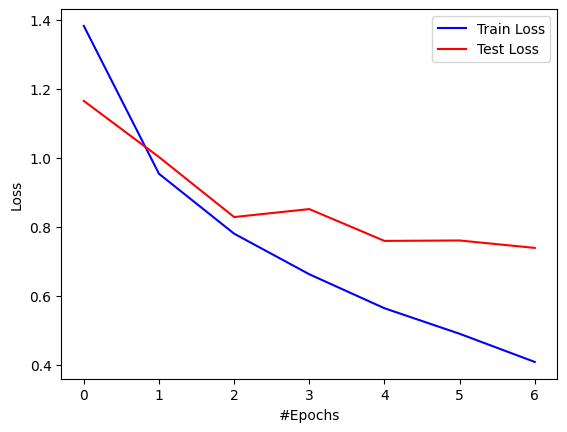

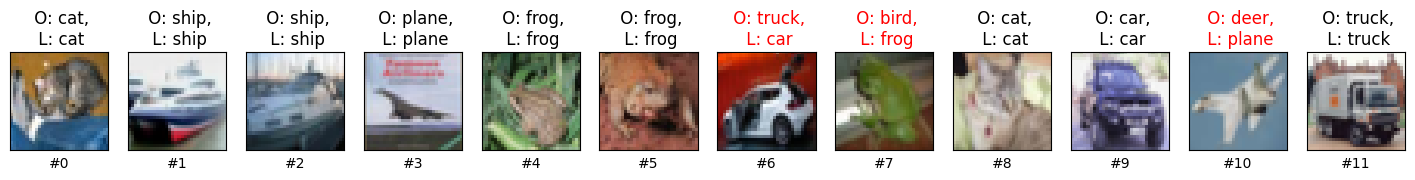

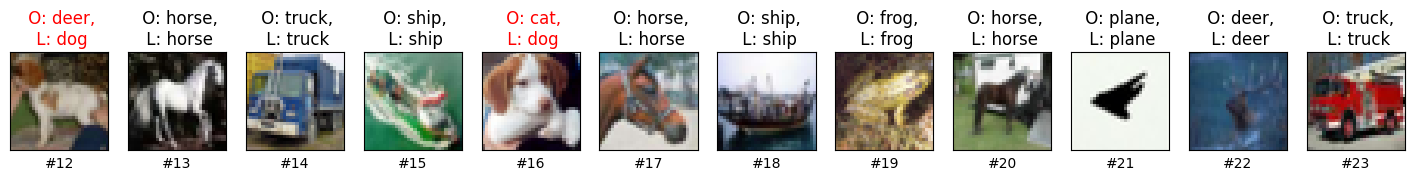

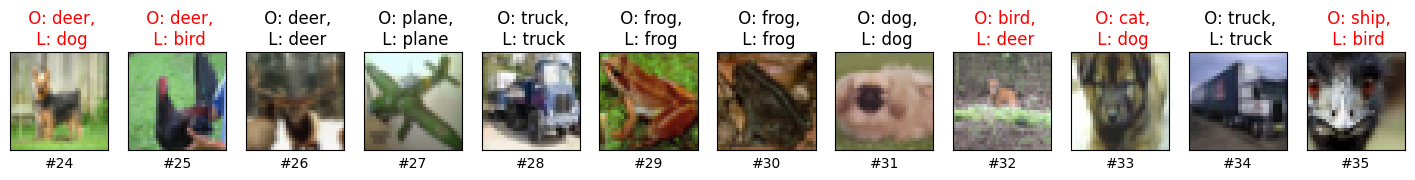

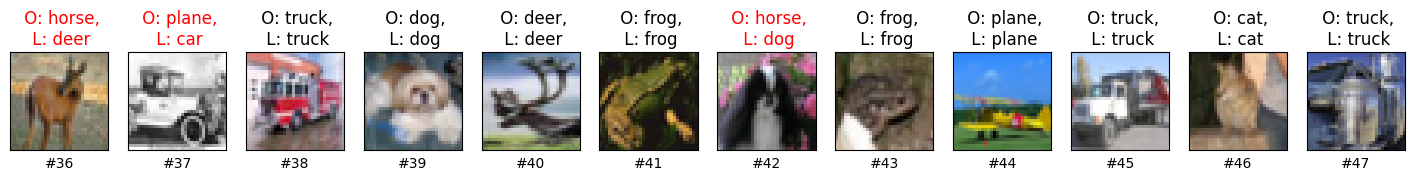

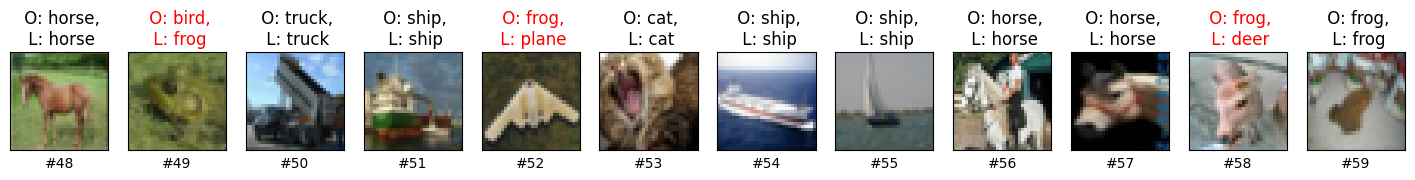

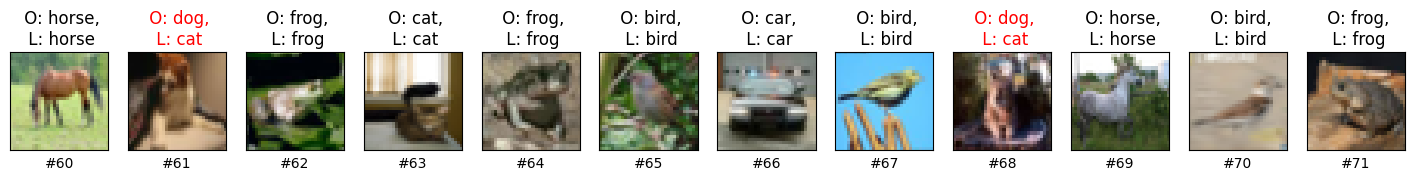

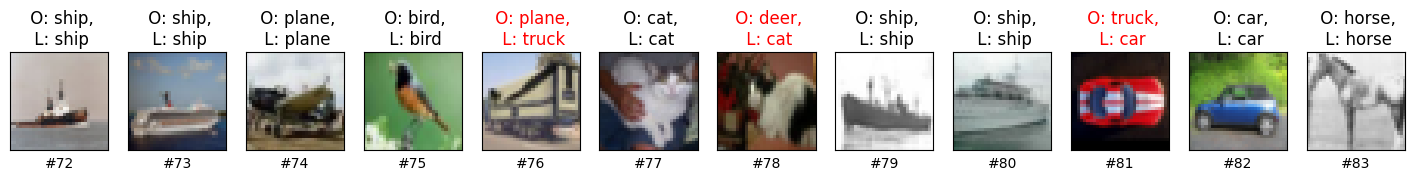

In [ ]:
#Training parameters
num_epochs = 7
print_interval = 1
learning_rate = 0.001
batch_size = 300
num_kernels = 10
kernel_size = 5

#Create model
network = CNNnew(image_w, image_h, kernel_size, 10)
network = network.to(device)

print("Num. Parameters:", count_parameters(network))

#Set optimizer and loss function
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)


print("Data is Loaded")

trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

computeLabelAccuracy(network, training_generator, "Train Set")
computeLabelAccuracy(network, testing_generator, "Test Set")
drawPredictionsCIFAR10(network, testing_dataset, 7, 12, 0)